<a href="https://colab.research.google.com/github/Chahinezehallaci/Chahinezehallaci/blob/main/Deep_Learning_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Learning

On veut classifier les images du fichier CIFAR 10 :
https://www.cs.toronto.edu/~kriz/cifar.html
Le fichier contient 50000 images pour l’apprentissage et 10000 pour le test.


1) Préparation des données

On pourra charger les données d’apprentissage avec les transformations suivantes :
- On centre et on normalise les 3 canaux.
- On recadre de façon aléatoire les images.
- On renverse la gauche et la droite de l’image de façon aléatoire.
- Les données de test doivent être uniquement centrées et normalisées.
- Les données d’apprentissage pourront être scindées en un ensemble d’entrainement et un ensemble de validation.


2) Estimer différents modèles de réseaux convolutifs sur ces données. Pour
les différents essais, donner le taux de bonnes prédictions sur l’ensemble
d’apprentissage (éventuellement de validation) et de test.



In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

import os
import argparse
import numpy as np

In [ ]:
# definition of hyperparameters
lr = 0.01 # taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-6
ne = 10
nsc = 3 #nombres d'itérations
gamma = 0.32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Chargement et Normalisation de l'ensemble de données de formation et de test CIFAR10 .

In [ ]:
# definition des hyperparameteres
# taux d'apprentissage initial, poids du gradient stochastique 
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.01, type=float, help='learning rate')
parser.add_argument('--resume', '--r', action='store_true', help='resume from checkpoint')
parser.add_argument('--nh', default=10, type=int, help='number of hidden unit')
#For compatibility with Jupyter
args = parser.parse_args([])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc =0  # best test accuracy
start_epoch =0  # start from epoch 0 or last checkpoint epoch

In [ ]:
# Pour avoir des experimentations reproductibles
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True)
x_training = train_set.data

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
test_set = torchvision.datasets.CIFAR10('./data', train=False, download=True)
x_test = test_set.data

Files already downloaded and verified


In [ ]:
K=len(x_training)
print("Nombre de classes:", K)

Nombre de classes: 50000


In [ ]:
K=len(x_test)
print("Nombre de classes:", K)

Nombre de classes: 10000


Ici, nous pouvons voir que nous avons 5000 images d’entraînement et que toutes les images sont de taille 32 par 32 et ont 3 canaux de couleur, c’est-à-dire que les images sont des images en couleur. 

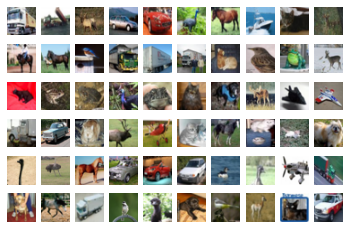

In [ ]:
# Montrons quelques observations:
figure = plt.figure()
num_of_images = 60

for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(x_training[index])

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


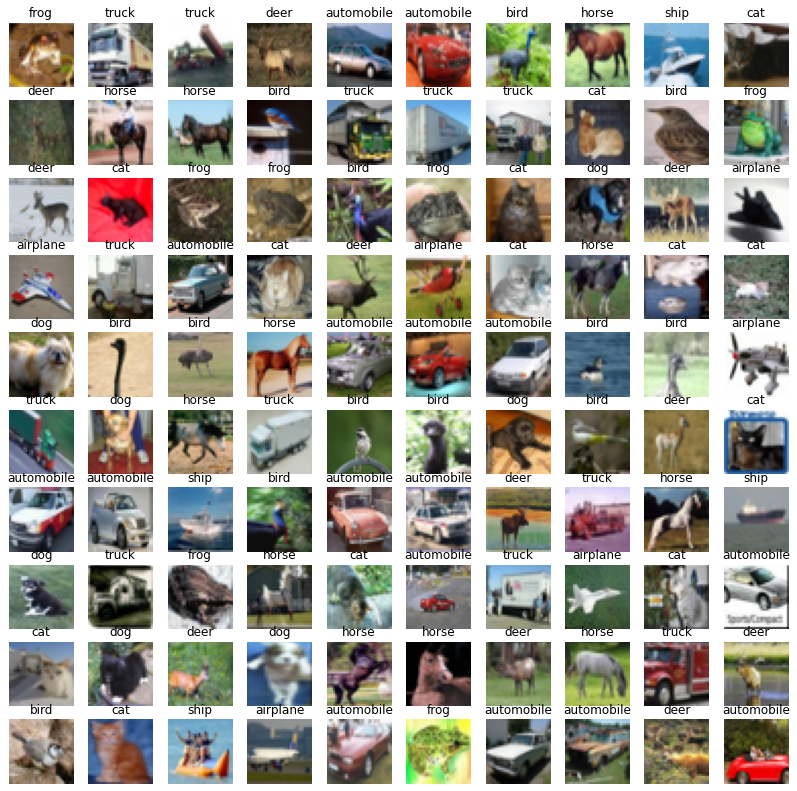

In [ ]:
import matplotlib.pyplot as plt

cifar_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

(X_train, y_train),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

fig = plt.figure(figsize=(14,14))
for i in range(100):
  ax = plt.subplot(10,10,i+1)
  ax.imshow(X_train[i])
  ax.axis('off')
  ax.set_title(cifar_classes[y_train[i,0]])

La sortie des ensembles de données torchvision sont des images de plage [0, 1]. Nous les transformons en Tenseurs de plage normalisée [-1, 1].  
Par exemple, la valeur minimale 0 sera convertie en (0-0.5)/0.5=-1, la valeur maximale 1 sera convertie en(1-0.5)/0.5=1.
 Pour chaque valeur d'une image,  torchvision.transforms.Normalize() soustrait la moyenne du canal et divise par l'écart type du canal.

In [ ]:
# Les données d’apprentissage
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4), # On recadre de façon aléatoire les images.
     transforms.RandomHorizontalFlip(), # On renverse la gauche et la droite de l’image de façon aléatoire.
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))]) #On centre et on normalise les 3 canaux.

In [ ]:
# Les données de test uniquement centrées et normalisées.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Les données d’apprentissage scindées en un ensemble d’entrainement et un ensemble de validation.
# Création de l'ensemble de validation

validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
split=5000
num_train=50000
indices = list(range(num_train))
np.random.seed(444)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
trainset = torch.utils.data.Subset(trainset,train_idx)
validset = torch.utils.data.Subset(validset,valid_idx)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


 Estimer différents modèles de réseaux convolutifs sur ces données. Pour
vos différents essais, donner le taux de bonnes prédictions sur l’ensemble
d’apprentissage (éventuellement de validation) et de test.

In [ ]:
# Constrution réseaux neuronnes VGG16 

# modèle de réseau neuronal à 13 couches

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layer1=nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.layer3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.layer4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.layer5 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.layer6 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.layer7 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.layer8 = nn.Conv2d(256,512,kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.layer9 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm2d(512)
        self.layer10 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm2d(512)
        self.layer11 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm2d(512)
        self.layer12 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.layer13 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn13 = nn.BatchNorm2d(512)
        self.classifier = nn.Linear(512, 10)
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(self.bn1(out)))
        out=F.max_pool2d(out,2)
#        print(out.size())
        out = F.relu(self.layer3(self.bn2(out)))
        out = F.relu(self.layer4(self.bn3(out)))
        out=F.max_pool2d(out,2)
#        print(out.size())        
        out = F.relu(self.layer5(self.bn4(out)))
        out = F.relu(self.layer6(self.bn5(out)))       
        out = F.relu(self.layer7(self.bn6(out)))     
        out=F.max_pool2d(out,2)
#        print(out.size())
        out = F.relu(self.layer8(self.bn7(out)))
        out = F.relu(self.layer9(self.bn8(out)))       
        out = F.relu(self.layer10(self.bn9(out)))     
        out=F.max_pool2d(out,2)
#        print(out.size())
        out = F.relu(self.layer11(self.bn10(out)))
        out = F.relu(self.layer12(self.bn11(out)))       
        out = F.relu(self.layer13(self.bn12(out)))     
        out=F.max_pool2d(out,2)
#        print(out.size())
        out = out.view(out.size(0), -1)
#        print(out.size())        
        out=self.classifier(out)
        return out

In [ ]:
net = VGG()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

In [ ]:

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += int(predicted.eq(targets).sum().item())
        #Only for linux without Jupyter
        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    #For Windows and or Jupyter
    print('pourcentage correct :',(100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            #Only for linux without Jupyter
            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
               # % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    #For Windows and/or Jupyter
    print('pourcentage correct :',(100.*correct/total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
        
def testfinal():
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7')
    net.load_state_dict(checkpoint['net'])
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            #Only for linux without Jupyter
            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    #For Windows and or Jupyter
    print('pourcentage correct :',(100.*correct/total))

In [ ]:
for epoch in range(start_epoch, start_epoch+10):
    train(epoch)
    test(epoch)


Epoch: 0
pourcentage correct : 47.03111111111111
pourcentage correct : 59.54
Saving..

Epoch: 1
pourcentage correct : 66.20222222222222
pourcentage correct : 69.56
Saving..

Epoch: 2
pourcentage correct : 73.89555555555556
pourcentage correct : 72.44
Saving..

Epoch: 3
pourcentage correct : 78.16
pourcentage correct : 78.2
Saving..

Epoch: 4
pourcentage correct : 80.52888888888889
pourcentage correct : 80.3
Saving..

Epoch: 5
pourcentage correct : 82.81111111111112
pourcentage correct : 81.38
Saving..

Epoch: 6
pourcentage correct : 84.34444444444445
pourcentage correct : 82.48
Saving..

Epoch: 7
pourcentage correct : 85.64666666666666
pourcentage correct : 83.44
Saving..

Epoch: 8
pourcentage correct : 86.89111111111112
pourcentage correct : 84.48
Saving..

Epoch: 9
pourcentage correct : 87.76444444444445
pourcentage correct : 84.6
Saving..


In [ ]:
# utilisation de Keras 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

num_classes = 10
input_shape = (32, 32, 3)

# definition of hyperparameters
lr = 0.001 # taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-7
ne = 10
nsc = 3 #nombres d'itérations
gamma = 0.32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),      
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


batch_size = 128 # la taille du lot d’images à charger.
epochs = 70

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 10) == 0:
    return lr * 0.32
  else:
    return lr

    
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


schedule = keras.callbacks.LearningRateScheduler(scheduler)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=datagen_test.flow(x_valid,y_valid,batch_size=100),validation_steps=50,callbacks=[schedule])

score = model.evaluate(datagen_test.flow(x_test, y_test,batch_size=100,shuffle=False),steps=len(x_test)/100)
print("Test accuracy:", score[1])

Epoch 1/70
351/351 [==============================] - 51s 140ms/step - loss: 2.1718 - accuracy: 0.3649 - val_loss: 1.7289 - val_accuracy: 0.4462 - lr: 0.0100
Epoch 2/70
351/351 [==============================] - 49s 140ms/step - loss: 1.8030 - accuracy: 0.4315 - val_loss: 1.3892 - val_accuracy: 0.4994 - lr: 0.0100
Epoch 3/70
351/351 [==============================] - 49s 138ms/step - loss: 1.4888 - accuracy: 0.5163 - val_loss: 1.2358 - val_accuracy: 0.5718 - lr: 0.0100
Epoch 4/70
351/351 [==============================] - 49s 140ms/step - loss: 1.4808 - accuracy: 0.5239 - val_loss: 1.8244 - val_accuracy: 0.4786 - lr: 0.0100
Epoch 5/70
351/351 [==============================] - 49s 138ms/step - loss: 1.2598 - accuracy: 0.5780 - val_loss: 1.1142 - val_accuracy: 0.6196 - lr: 0.0100
Epoch 6/70
351/351 [==============================] - 49s 138ms/step - loss: 1.1546 - accuracy: 0.6255 - val_loss: 1.0540 - val_accuracy: 0.6342 - lr: 0.0100
Epoch 7/70
351/351 [==============================] 

In [ ]:
# utilisation de Keras 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

num_classes = 10
input_shape = (32, 32, 3)

# definition of hyperparameters
lr = 0.001 # taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-6
ne = 20
nsc = 3 #nombres d'itérations
gamma = 0.32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),      
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


batch_size = 128 # la taille du lot d’images à charger.
epochs = 80

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 10) == 0:
    return lr * 0.32
  else:
    return lr

    
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


schedule = keras.callbacks.LearningRateScheduler(scheduler)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=datagen_test.flow(x_valid,y_valid,batch_size=100),validation_steps=50,callbacks=[schedule])

score = model.evaluate(datagen_test.flow(x_test, y_test,batch_size=100,shuffle=False),steps=len(x_test)/100)
print("Test accuracy:", score[1])

Epoch 1/80
351/351 [==============================] - 51s 141ms/step - loss: 2.1796 - accuracy: 0.3565 - val_loss: 18.6138 - val_accuracy: 0.1908 - lr: 0.0100
Epoch 2/80
351/351 [==============================] - 49s 139ms/step - loss: 1.8777 - accuracy: 0.4115 - val_loss: 1.4896 - val_accuracy: 0.4804 - lr: 0.0100
Epoch 3/80
351/351 [==============================] - 49s 138ms/step - loss: 1.5822 - accuracy: 0.4778 - val_loss: 1.4127 - val_accuracy: 0.5280 - lr: 0.0100
Epoch 4/80
351/351 [==============================] - 49s 140ms/step - loss: 1.5020 - accuracy: 0.5104 - val_loss: 3.5726 - val_accuracy: 0.3756 - lr: 0.0100
Epoch 5/80
351/351 [==============================] - 49s 140ms/step - loss: 1.4814 - accuracy: 0.5244 - val_loss: 1.5740 - val_accuracy: 0.5274 - lr: 0.0100
Epoch 6/80
351/351 [==============================] - 49s 141ms/step - loss: 1.2739 - accuracy: 0.5712 - val_loss: 1.2640 - val_accuracy: 0.5906 - lr: 0.0100
Epoch 7/80
351/351 [==============================]

KeyboardInterrupt: ignored

In [ ]:
# utilisation de Keras 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

num_classes = 10
input_shape = (32, 32, 3)

# definition of hyperparameters
lr = 0.001 # taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-6
ne = 20
nsc = 3 #nombres d'itérations
gamma = 0.32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),      
        layers.Flatten(),
        layers.Dense(4096, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


batch_size = 128 # la taille du lot d’images à charger.
epochs = 80

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 10) == 0:
    return lr * 0.32
  else:
    return lr

    
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


schedule = keras.callbacks.LearningRateScheduler(scheduler)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=datagen_test.flow(x_valid,y_valid,batch_size=100),validation_steps=50,callbacks=[schedule])

score = model.evaluate(datagen_test.flow(x_test, y_test,batch_size=100,shuffle=False),steps=len(x_test)/100)
print("Test accuracy:", score[1])

Epoch 1/80
351/351 [==============================] - 64s 176ms/step - loss: 1.6328 - accuracy: 0.3998 - val_loss: 1.4700 - val_accuracy: 0.4530 - lr: 0.0100
Epoch 2/80
351/351 [==============================] - 62s 175ms/step - loss: 1.2634 - accuracy: 0.5447 - val_loss: 1.1868 - val_accuracy: 0.5926 - lr: 0.0100
Epoch 3/80
351/351 [==============================] - 61s 174ms/step - loss: 1.0557 - accuracy: 0.6228 - val_loss: 1.0854 - val_accuracy: 0.6262 - lr: 0.0100
Epoch 4/80
351/351 [==============================] - 61s 174ms/step - loss: 0.8860 - accuracy: 0.6903 - val_loss: 0.9524 - val_accuracy: 0.6802 - lr: 0.0100
Epoch 5/80
351/351 [==============================] - 61s 174ms/step - loss: 0.7577 - accuracy: 0.7355 - val_loss: 0.7587 - val_accuracy: 0.7364 - lr: 0.0100
Epoch 6/80
351/351 [==============================] - 61s 174ms/step - loss: 0.6635 - accuracy: 0.7704 - val_loss: 0.6887 - val_accuracy: 0.7638 - lr: 0.0100
Epoch 7/80
351/351 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
# utilisation de Keras pour VGG 19 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

num_classes = 10
input_shape = (32, 32, 3)

# definition of hyperparameters
lr = 0.1# taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-6
ne = 20
nsc = 3 #nombres d'itérations
gamma = 0.35

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),      
        layers.Flatten(),
        layers.Dense(4096, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

batch_size = 128 # la taille du lot d’images à charger.
epochs = 80

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 10) == 0:
    return lr * 0.32
  else:
    return lr

    
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


schedule = keras.callbacks.LearningRateScheduler(scheduler)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=datagen_test.flow(x_valid,y_valid,batch_size=100),validation_steps=50,callbacks=[schedule])

score = model.evaluate(datagen_test.flow(x_test, y_test,batch_size=100,shuffle=False),steps=len(x_test)/100)
print("Test accuracy:", score[1])

Epoch 1/80
351/351 [==============================] - 64s 176ms/step - loss: 1.6229 - accuracy: 0.4010 - val_loss: 1.4138 - val_accuracy: 0.4918 - lr: 0.0100
Epoch 2/80
351/351 [==============================] - 62s 176ms/step - loss: 1.2553 - accuracy: 0.5483 - val_loss: 1.2079 - val_accuracy: 0.5782 - lr: 0.0100
Epoch 3/80
351/351 [==============================] - 61s 174ms/step - loss: 1.0463 - accuracy: 0.6298 - val_loss: 1.0849 - val_accuracy: 0.6214 - lr: 0.0100
Epoch 4/80
351/351 [==============================] - 61s 174ms/step - loss: 0.8756 - accuracy: 0.6914 - val_loss: 0.8203 - val_accuracy: 0.7150 - lr: 0.0100
Epoch 5/80
351/351 [==============================] - 61s 174ms/step - loss: 0.7467 - accuracy: 0.7392 - val_loss: 0.7321 - val_accuracy: 0.7582 - lr: 0.0100
Epoch 6/80
351/351 [==============================] - 61s 174ms/step - loss: 0.6560 - accuracy: 0.7732 - val_loss: 0.7232 - val_accuracy: 0.7594 - lr: 0.0100
Epoch 7/80
351/351 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
# utilisation de Keras pour VGG 19 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

num_classes = 10
input_shape = (32, 32, 3)

# definition of hyperparameters
lr = 0.05# taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-6
ne = 15 
nsc = 2 #nombres d'itérations
gamma = 0.35

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),      
        layers.Flatten(),
        layers.Dense(4096, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

batch_size = 128 # la taille du lot d’images à charger.
epochs = 40

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 10) == 0:
    return lr * 0.32
  else:
    return lr

    
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


schedule = keras.callbacks.LearningRateScheduler(scheduler)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=datagen_test.flow(x_valid,y_valid,batch_size=100),validation_steps=50,callbacks=[schedule])

score = model.evaluate(datagen_test.flow(x_test, y_test,batch_size=128,shuffle=False),steps=len(x_test)/100)
print("Test accuracy:", score[1])

Epoch 1/40
351/351 [==============================] - 65s 176ms/step - loss: 1.6259 - accuracy: 0.3962 - val_loss: 1.4228 - val_accuracy: 0.4784 - lr: 0.0100
Epoch 2/40
351/351 [==============================] - 62s 175ms/step - loss: 1.2511 - accuracy: 0.5481 - val_loss: 1.2391 - val_accuracy: 0.5502 - lr: 0.0100
Epoch 3/40
351/351 [==============================] - 61s 174ms/step - loss: 1.0342 - accuracy: 0.6350 - val_loss: 0.9846 - val_accuracy: 0.6492 - lr: 0.0100
Epoch 4/40
351/351 [==============================] - 61s 173ms/step - loss: 0.8610 - accuracy: 0.6995 - val_loss: 0.9432 - val_accuracy: 0.6818 - lr: 0.0100
Epoch 5/40
351/351 [==============================] - 61s 174ms/step - loss: 0.7393 - accuracy: 0.7443 - val_loss: 0.7528 - val_accuracy: 0.7482 - lr: 0.0100
Epoch 6/40
351/351 [==============================] - 61s 174ms/step - loss: 0.6563 - accuracy: 0.7711 - val_loss: 0.6446 - val_accuracy: 0.7770 - lr: 0.0100
Epoch 7/40
351/351 [==============================] 

In [ ]:
# utilisation de Keras pour VGG 19 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

num_classes = 10
input_shape = (32, 32, 3)

# definition of hyperparameters
lr = 0.05# taux d'apprentissage initial, poids du gradient stochastique 
wd = 1e-6
ne = 60
nsc = 20 #nombres d'itérations
gamma = 0.35

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.Conv2D(256, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),  
        layers.Conv2D(512, kernel_size=(3, 3), padding = "same", activation="relu"),
        layers.BatchNormalization(),     
        layers.MaxPooling2D(pool_size=(2, 2)),      
        layers.Dropout(0.3),     
        layers.Flatten(),
        layers.Dense(4096, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

batch_size = 128 # la taille du lot d’images à charger.
epochs = 40

def scheduler(epoch, lr):
  if epoch == 0:
    return lr
  if (epoch % 10) == 0:
    return lr * 0.32
  else:
    return lr

    
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


schedule = keras.callbacks.LearningRateScheduler(scheduler)

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) / batch_size, epochs=epochs, validation_data=datagen_test.flow(x_valid,y_valid,batch_size=100),validation_steps=50,callbacks=[schedule])

score = model.evaluate(datagen_test.flow(x_test, y_test,batch_size=128,shuffle=False),steps=len(x_test)/100)
print("Test accuracy:", score[1])

Epoch 1/40
351/351 [==============================] - 77s 185ms/step - loss: 1.6277 - accuracy: 0.3989 - val_loss: 1.3909 - val_accuracy: 0.4984 - lr: 0.0100
Epoch 2/40
351/351 [==============================] - 62s 177ms/step - loss: 1.2486 - accuracy: 0.5484 - val_loss: 1.2618 - val_accuracy: 0.5550 - lr: 0.0100
Epoch 3/40
351/351 [==============================] - 62s 175ms/step - loss: 1.0328 - accuracy: 0.6351 - val_loss: 1.1153 - val_accuracy: 0.6348 - lr: 0.0100
Epoch 4/40
351/351 [==============================] - 62s 175ms/step - loss: 0.8539 - accuracy: 0.7019 - val_loss: 0.9114 - val_accuracy: 0.6962 - lr: 0.0100
Epoch 5/40
351/351 [==============================] - 61s 175ms/step - loss: 0.7375 - accuracy: 0.7445 - val_loss: 0.7501 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 6/40
351/351 [==============================] - 62s 175ms/step - loss: 0.6454 - accuracy: 0.7778 - val_loss: 0.6743 - val_accuracy: 0.7696 - lr: 0.0100
Epoch 7/40
351/351 [==============================] 